## Requirement modules

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install box2d-py
!pip3 install box2d box2d-kengz
!pip install pybox2d

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (57.0.0)


## Display Making for recording videos

In [ ]:
# Display Making
!rm -rf video
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

## Environment Initializing 

In [ ]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
import numpy as np
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

env = gym.make("LunarLander-v2")
print('observation space:', env.observation_space)
print('action space:', env.action_space)

obs = env.reset()
#env.render()
print('initial observation:', obs)

action = env.action_space.sample()
n_obs, r, done, info = env.step(action)
print('next observation:', n_obs)
print('reward:', r)
print('done:', done)
print('info:', info)




observation space: Box(-inf, inf, (8,), float32)
action space: Discrete(4)
initial observation: [ 0.00358639  1.4003816   0.3632449  -0.4683797  -0.00414893 -0.08228043
  0.          0.        ]
next observation: [ 0.00726328  1.3892561   0.3741002  -0.49449843 -0.01049109 -0.1268553
  0.          0.        ]
reward: -2.286735362561443
done: False
info: {}


## Gradient Descent Implimentation for DQN

In [ ]:
import random
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from collections import deque 
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential


class Agent():
    def __init__(self, nS, nA, alpha, gamma, epsilon, epsilon_min, 
                 epsilon_decay):
        self.nS = nS    #Number of States
        self.nA = nA    #Number of Actions
        self.memory = deque([], maxlen=250000)
        self.alpha = alpha    #Learning Rate
        self.gamma = gamma    #Discount Rate in Bellman approximation
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.loss = []
        random.seed(8)
        
    def build_model(self):
        model = keras.Sequential()
        #[Input] -> Layer 1
        model.add(keras.layers.Dense(256, input_dim=self.nS, activation='relu'))
        #[Hidden] -> Layer 2
        model.add(keras.layers.Dense(128, activation='relu')) 
        #[Hidden] -> Layer 3
        model.add(keras.layers.Dense(32, activation='relu')) 
        #[output] -> Layer 4
        model.add(keras.layers.Dense(self.nA, activation='linear')) 
        model.compile(loss='mean_squared_error',
                      optimizer=keras.optimizers.Adam(lr=self.alpha))
        return model


    def action(self, state):
        if np.random.rand() <= self.epsilon:
          #Explore
          return random.randrange(self.nA)
        else:
          #Exploit: Use the NN to predict the correct action from this state
          action_vals = self.model.predict_on_batch(state) 
          return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict_on_batch(state)
        return np.argmax(action_vals[0]),action_vals[0]

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def update_NN(self, batch_size):
        states, actions, rewards, next_states, done_list = self.random_sample(batch_size)
        targets = rewards + self.gamma * (np.amax(self.model.predict_on_batch(next_states),
                                                  axis=1)) * (1 - done_list)
        target_vec = self.model.predict_on_batch(states)
        indexes = np.array([i for i in range(batch_size)])
        target_vec[[indexes], [actions]] = targets

        epoch_count = 1 #Epochs is the number or iterations
        hist = self.model.fit(states, target_vec, epochs=epoch_count, verbose=0)

        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            #self.epsilon = e/EPISODES
    
    def random_sample(self, batch_size):
        #Execute the experience replay
        #Randomly sample from memory
        minibatch = random.sample( self.memory, batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        done_list = np.array([i[4] for i in minibatch])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return states, actions, rewards, next_states, done_list
        
    def save(self, name):
        self.model.save(name)

def Convergence_coundition(episode, step, reward_for_episode, 
                           rewards_list, can_stop, epsilon):
  # Check for convergence condition
  last_rewards_mean = np.mean(rewards_list[-100:]) #-100 instead of -10
  if last_rewards_mean >= 150 and can_stop:
    print("DQN Training Complete...")
    # Save Everything
    save_dir = "saved_models"
    # Save trained model
    agent.save(save_dir + "trained_model.h5")
    return True
  else:  
    print("Episode:", episode, "  || Step: ", step,  "  || Reward: ",
          reward_for_episode, "  || Average Reward: ",last_rewards_mean,
          "  || epsilon: ", epsilon )
  
def plot_reward(df_reward, chart_name, title, x_axis_label, y_axis_label):
    plt.rcParams.update({'font.size': 17})
    df_reward['rolling mean 100'] = df_reward[df_reward.columns[0]].rolling(100).mean()
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df_reward.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((-800, 300))
    fig = plot.get_figure()
    plt.legend().set_visible(True)
    fname="/content/drive/MyDrive/IUST (Master)/AI/Control Spaceship_RL/Batch=1024_NN-256-128-32_lr=0.001_dr=0.99_ed=0.996/"
    fig.savefig(fname + chart_name)

def plot_df(df, chart_name, title, x_axis_label, y_axis_label):
    df['rolling mean 100'] = df[df.columns[0]].rolling(100).mean()
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((0, 200))
    plt.xlim((0, 2000))
    plt.legend().set_visible(True)
    fig = plot.get_figure()
    fname="/content/drive/MyDrive/IUST (Master)/AI/Control Spaceship_RL/Batch=1024_NN-256-128-32_lr=0.001_dr=0.99_ed=0.996/"
    fig.savefig(fname + chart_name)
  
def plot_comp(df_reward, chart_name, title, x_axis_label, y_axis_label):
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df_reward.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((-800, 300))
    fig = plot.get_figure()
    plt.legend().set_visible(True)
    fname="/content/drive/MyDrive/IUST (Master)/AI/Control Spaceship_RL/Batch=1024_NN-256-128-32_lr=0.001_dr=0.99_ed=0.996/"
    fig.savefig(fname + chart_name)

## GA Implimentation

In [ ]:
import random
import math
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from collections import deque 
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential


class Agent_GA():
    def __init__(self, nS, nA, nP, initial_pop, best_pop, gamma, epsilon,
                 epsilon_min, epsilon_decay):
        self.nS = nS    #Number of States
        self.nA = nA    #Number of Actions
        self.nP = nP    #Number of Population
        self.nvar = 39040
        self.memory = deque([], maxlen=250000)
        self.gamma = gamma    #Discount Rate in Bellman approximation
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        #self.model = self.feedforward()
        self.pop_weights = initial_pop
        self.best_weights = best_pop
        self.loss = []
        #self.activ_function()
        random.seed(8)
        
    #def active_function(self, )
    def feedforward(self, states):
        
        def active_fun(input):
            # THIS IS RELU FUNCTION
            o = np.zeros((len(input), 1))
            for i in range(len(input)):
              if input[i, 0]<=0:
                o[i, 0]=0
              else:
                o[i, 0]=input[i, 0]
            return o

        n_data = states.shape[0]  #data must be array or matrix
        n0 = self.nS
        n1 = 256
        n2 = 128
        n3 = 32
        n4 = self.nA

        data = np.asmatrix(states)

        w = self.best_weights #weight is (1, 39040)

        w1 = np.reshape(w[0, 0:n1*n0], (n1, n0))
        w1 = np.asmatrix(w1)
        net1 = np.zeros((n1, 1))
        net1 = np.asmatrix(net1)
        o1 = np.zeros((n1, 1))
        o1 = np.asmatrix(o1)

        w2 = np.reshape(w[0, n1*n0:(n1*n0+n2*n1)], (n2, n1))
        w2 = np.asmatrix(w2)
        net2 = np.zeros((n2, 1))
        net2 = np.asmatrix(net2)
        o2 = np.zeros((n2, 1))
        o2 = np.asmatrix(o2)

        w3 = np.reshape(w[0, (n1*n0+n2*n1):(n1*n0+n2*n1+n3*n2)], (n3, n2))
        w3 = np.asmatrix(w3)
        net3 = np.zeros((n3, 1))
        net3 = np.asmatrix(net3)
        o3 = np.zeros((n3, 1))
        o3 = np.asmatrix(o3)

        w4 = np.reshape(w[0, (n1*n0+n2*n1+n3*n2):(n1*n0+n2*n1+n3*n2+n4*n3)],
                        (n4, n3))
        w4 = np.asmatrix(w4)
        net4 = np.zeros((n4, 1))
        net4 = np.asmatrix(net4)
        o4 = np.zeros((n4, 1))
        o4 = np.asmatrix(o4)
        output = np.zeros((n_data, n4))
        #output = np.asmatrix(output)

        for j in range(n_data):
          Input = data[j, :]
          
          net1 = w1 * (Input.transpose())
          o1 = active_fun(net1)
          net2 = w2 * o1
          o2 = active_fun(net2)
          net3 = w3 * o2
          o3 = active_fun(net3)
          net4 = w4 * o3
          o4 = net4
          out = np.asarray(o4).reshape(4,)
          output[j, :] = out
        
        return output  #is 2D array (1, number of action)
      

    def fitness(self, data_in, target):
        def active_fun(input):
            # THIS IS RELU FUNCTION
            o = np.zeros((len(input), 1))
            for i in range(len(input)):
              if input[i, 0]<=0:
                o[i, 0]=0
              else:
                o[i, 0]=input[i, 0]
            return o

        n_data = data_in.shape[0]  #data must be array or matrix
        w = self.pop_weights #weights is (pop, 39040)

        n0 = self.nS
        n1 = 256
        n2 = 128
        n3 = 32
        n4 = self.nA
        p = w.shape[0]

        data_in = np.asmatrix(data_in)
        target = np.asmatrix(target)

        #w = self.pop_weights #weights is (pop, 39040)

        w1 = np.reshape(w[:, 0:n1*n0], (p, n1, n0))
        #w1 = np.asmatrix(w1)
        net1 = np.zeros((n1, 1))
        net1 = np.asmatrix(net1)
        o1 = np.zeros((n1, 1))
        o1 = np.asmatrix(o1)

        w2 = np.reshape(w[:, n1*n0:(n1*n0+n2*n1)], (p, n2, n1))
        #w2 = np.asmatrix(w2)
        net2 = np.zeros((n2, 1))
        net2 = np.asmatrix(net2)
        o2 = np.zeros((n2, 1))
        o2 = np.asmatrix(o2)

        w3 = np.reshape(w[:, (n1*n0+n2*n1):(n1*n0+n2*n1+n3*n2)], (p, n3, n2))
        #w3 = np.asmatrix(w3)
        net3 = np.zeros((n3, 1))
        net3 = np.asmatrix(net3)
        o3 = np.zeros((n3, 1))
        o3 = np.asmatrix(o3)

        w4 = np.reshape(w[:, (n1*n0+n2*n1+n3*n2):(n1*n0+n2*n1+n3*n2+n4*n3)], 
                        (p, n4, n3))
        #w4 = np.asmatrix(w4)
        net4 = np.zeros((n4, 1))
        net4 = np.asmatrix(net4)
        o4 = np.zeros((n4, 1))
        o4 = np.asmatrix(o4)
        
        e = np.zeros((p, n_data))
        
        

        for i in range(p):
          for j in range(n_data):
            Input = data_in[j, :]
            
            w12 = np.asmatrix(w1[i, :, :])
            net1 = w12 * (Input.transpose())
            o1 = active_fun(net1)

            w23 = np.asmatrix(w2[i, :, :])
            net2 = w23 * o1
            o2 = active_fun(net2)

            w34 = np.asmatrix(w3[i, :, :])
            net3 = w34 * o2
            o3 = active_fun(net3)

            w45 = np.asmatrix(w4[i, :, :])
            net4 = w45 * o3
            o4 = net4
            e[i, j] = np.abs(target[j, :] - o4.transpose()).mean()
        
        fit = e.mean(axis=1)  #1D array
        return fit
        
    def GA(self, data_in, target, epochs):
        
        #DEFINE CROSSOVER FUNCTION
        def crossover(fit, ncross, pop):

            def UniformCrossOver(x1, x2):
                R1 = np.random.uniform(0, 1, size=x1.shape)
                R2 = 1-R1
                y1=np.multiply(R1, x1)+np.multiply(R2, x2)
                y2=np.multiply(R2, x1)+np.multiply(R1, x2)
                return y1, y2

            p = fit/(fit.sum())
            p_cum = p.cumsum()
            crosspop = np.zeros((ncross, self.nvar))
            for n in range(ncross):
              if (n%2==0):
                i1 = [index for index, value in enumerate(p_cum) if value<random.random()]
                i2 = [index for index, value in enumerate(p_cum) if value<random.random()]
                if len(i1)==0 or len(i2)==0:
                  i1 = random.randint(0, len(p_cum)-1)
                  i2 = random.randint(0, len(p_cum)-1)
                else:
                  i1 = i1[-1]
                  i2 = i2[0]
                (crosspop[n, :], crosspop[n+1, :])=UniformCrossOver(pop[i1, :],
                                                                    pop[i2, :])
            return crosspop

        # DEFINE MUTATION FUNCTION
        def mutation(nmut, pop):

            def UniformMutation(x, R):
                n = self.nvar
                I = np.random.randint(0, n-1, size=(math.floor(R*n),))
                d = np.random.uniform(-0.1, 0.1, size=(n,))
                x[I] = x[I]+d[I]
                y=x
                return y

            R = 0.01
            mutpop = np.zeros((nmut, self.nvar))
            for n in range(nmut):
                i1=random.randint(0, self.nP-1)
                mutpop[n, :] = UniformMutation(pop[i1, :], R) 
            return mutpop

        
        npop=self.nP     #number of population
        pop = self.pop_weights
        pc=0.7           #percent of crossover
        ncross=2*round(npop*pc/2)  #number of crossover offspring

        pm=0.3                      #percent of mutation
        nmut=round(npop*pm)         #number of mutation offspring
        
        for k in range(epochs):
          fit = self.fitness(data_in, target)
          #crossover
          crosspop = crossover(fit, ncross, pop)
          
          #mutation
          mutpop = mutation(nmut, pop)

          #merged
          pop_new = np.concatenate((pop, crosspop, mutpop), axis=0)
          self.pop_weights = pop_new[npop:, :]
          
          #Sorting
          fit_new = np.concatenate((fit, self.fitness(data_in, target)), axis=0)
          pop_with_fit = np.concatenate((pop_new, fit_new.reshape(-1, 1)),
                                        axis=1)
          pop_with_fit[:, -1].sort()
          #pop_with_fit = pop_with_fit[::-1]
          

          

          #selecting
          self.pop_weights = pop_with_fit[:npop, :-1]
          self.best_weights = pop_with_fit[0, :-1].reshape(1, -1)
          self.loss.append(pop_with_fit[0, -1])

    def action(self, state):
        if np.random.rand() <= self.epsilon:
          #Explore
          return random.randrange(self.nA)
        else:
          #Exploit: Use the NN to predict the correct action from this state
          action_vals = self.feedforward(state) 
          return np.argmax(action_vals)

    def test_action(self, state): #Exploit
        action_vals = self.feedforward(state)
        return np.argmax(action_vals)

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def random_sample(self, batch_size):
        #Execute the experience replay
        #Randomly sample from memory
        minibatch = random.sample( self.memory, batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        done_list = np.array([i[4] for i in minibatch])
        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        return states, actions, rewards, next_states, done_list

    def update_NN(self, batch_size):
        states, actions, rewards, next_states, done_list = self.random_sample(batch_size)
        targets = rewards + self.gamma * (np.amax(self.feedforward(next_states),
                                                  axis=1)) * (1 - done_list)
        target_vec = self.feedforward(states)
        indexes = np.array([i for i in range(batch_size)])
        target_vec[[indexes], [actions]] = targets

        epoch_count = 1 #Epochs is the number or iterations
        self.GA(states, target_vec, epochs=epoch_count)   #GA algorithem

        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            #self.epsilon = e/EPISODES
    
    
        
    def save(self, name):
        b_weights = self.best_weights
        columns_name1 = ['BEST WEIGHTS']
        b_weights_df = pd.DataFrame(b_weights.reshape(-1, 1),
                                    columns=columns_name1)
        b_weights_df.to_csv(save_dir + 'Model_weights.csv')

def Convergence_coundition(episode, step, reward_for_episode, 
                           rewards_list, can_stop, epsilon):
  # Check for convergence condition
  last_rewards_mean = np.mean(rewards_list[-100:]) #-100 instead of -10
  if last_rewards_mean >= 150 and can_stop:
    print("DQN Training Complete...")
    # Save Everything
    save_dir = "saved_models"
    # Save trained model
    agent_GA.save(save_dir + "trained_model.h5")
    return True
  else:  
    print("Episode:", episode, "  || Step: ", step,  "  || Reward: ",
          reward_for_episode, "  || Average Reward: ",last_rewards_mean,
          "  || epsilon: ", epsilon )
  
def plot_reward(df_reward, chart_name, title, x_axis_label, y_axis_label):
    plt.rcParams.update({'font.size': 17})
    df_reward['rolling mean 100'] = df_reward[df_reward.columns[0]].rolling(100).mean()
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df_reward.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((-800, 300))
    fig = plot.get_figure()
    plt.legend().set_visible(True)
    fname="/content/drive/MyDrive/IUST (Master)/AI/Control Spaceship_RL/GA_1/"
    fig.savefig(fname + chart_name)

def plot_df(df, chart_name, title, x_axis_label, y_axis_label):
    df['rolling mean 100'] = df[df.columns[0]].rolling(100).mean()
    plt.rcParams.update({'font.size': 17})
    plt.figure(figsize=(15, 8))
    plt.close()
    plt.figure()
    # plot = df.plot(linewidth=1.5, figsize=(15, 8), title=title)
    plot = df.plot(linewidth=1.5, figsize=(15, 8))
    plot.set_xlabel(x_axis_label)
    plot.set_ylabel(y_axis_label)
    plt.ylim((0,6000))
    plt.xlim((0, 2000))
    plt.legend().set_visible(True)
    fig = plot.get_figure()
    fname="/content/drive/MyDrive/IUST (Master)/AI/Control Spaceship_RL/GA_1/"
    fig.savefig(fname + chart_name)
    

## Setting HyperParameter

In [ ]:
#Hyper Parameters
def discount_rate(): #Gamma
    return 0.99

def learning_rate(): #Alpha
    return 0.001  

def ini_pop(n_pop, n_var, lb, hb): #initial population
    pop = np.random.uniform(lb, hb, size=(n_pop, n_var))
    return pop

def batch_size(): #Size of the batch used in the experience replay
    return 1024

def epsilon(): 
    return 1

def epsilon_min():
    return 0.01  

def epsilon_decay():
    return 0.996

## Choosing an Agent for the Model

### Gradien discent Agent

In [ ]:
env = wrap_env(gym.make("LunarLander-v2"))
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n

agent = Agent(n_states, n_actions, learning_rate(), discount_rate(), epsilon(),
              epsilon_min(), epsilon_decay())

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### GA Agent

In [ ]:
env = wrap_env(gym.make("LunarLander-v2"))
n_states = env.observation_space.shape[0]
n_actions = env.action_space.n
n_pop = 10
pop = ini_pop(n_pop, 39040, -1, 1)
best_pop = pop[0, :].reshape(1, -1)
agent = Agent_GA(n_states, n_actions, n_pop, pop, best_pop, discount_rate(),
                    epsilon(), epsilon_min(), epsilon_decay())



## Environment

In [ ]:


random.seed(8)
#obs = env.reset()

Episode = 2000
epi=0
Total_reward = []

for epi in range(Episode):
    step=0
    reward_e=0
    done = False
    obs = env.reset()
    while not done:
          env.render()
          obs = np.reshape(obs, [1, n_states])
          action = agent.action(obs) 
          next_obs, reward, done, info = env.step(action)
          agent.store(obs, action, reward, next_obs, done) 
          step+=1
          reward_e += reward
          obs = next_obs
    
    if len(agent.memory) >= batch_size():
       agent.update_NN(batch_size())
    
    Total_reward.append(reward_e)
    conv=Convergence_coundition(epi, step, reward_e, Total_reward, can_stop=True,
                                epsilon=agent.epsilon)
    if conv:
       break
  
            
env.close()
show_video()

## Saving Model

In [ ]:
# Save Everything
save_dir = "/content/drive/MyDrive/IUST (Master)/AI/Control Spaceship_RL/GA_1/"
# Save trained model
agent.save(save_dir + "trained_model.h5")



## Result

In [ ]:
# plot reward in graph
columns_name1 = ['Reward in each episode']
reward_df = pd.DataFrame(Total_reward, columns=columns_name1)
reward_df.to_csv(save_dir + 'Average reward.csv')
#Must be changed to plot_reward
plot_reward(reward_df, "Figure 1: Reward for each training episode", 
            "Reward for each training episode", "Episode","Reward")

# plot loss in graph
loss_df = pd.DataFrame(agent.loss, columns=['NN loss in each episode'])
loss_df_arr = np.array(loss_df)
print(loss_df_arr.shape)
#Must be changed to plot_reward
plot_df(loss_df, "Figure 2: Loss for each NN training", 
        "Loss for each NN training", "Episode","Loss")

#Save Data
reward_df.to_csv(save_dir + 'Average reward.csv', index=False)
loss_df.to_csv(save_dir + 'NN Loss.csv', index=False)
loss_df.head(-5)

### Models Comparison

<Figure size 432x288 with 0 Axes>

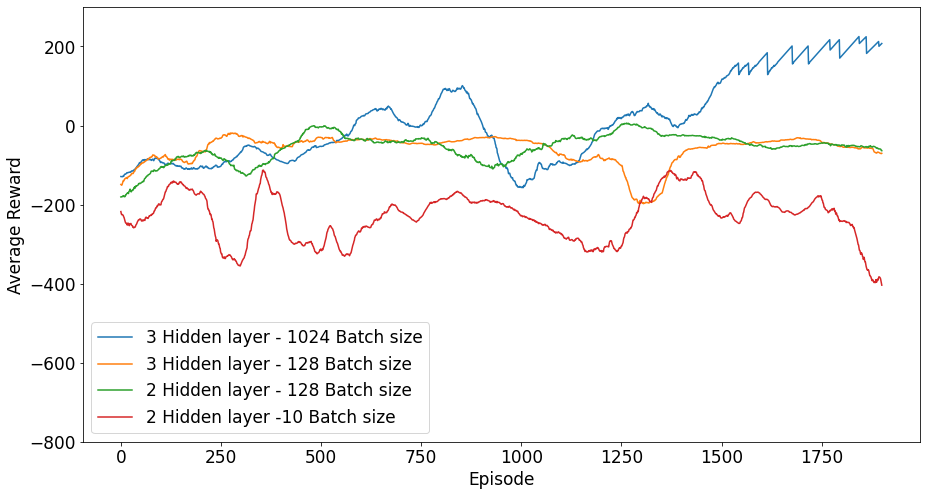

In [ ]:
Avreward_df = pd.read_csv("/content/drive/MyDrive/IUST (Master)/AI/Control Spaceship_RL/Average Reward comparison.csv")

plot_comp(Avreward_df, "Figure 3: Avearge Reward comparison", 
            "Hyper Parameters Comparison", "Episode", "Average Reward")